In [49]:
import numpy as np
from google.colab import drive
drive.mount("./gdrive")
drive_root_dir = "./gdrive/My Drive/"

from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:,2:-2,2:-2,:])) /scaling

dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss,grads]
fetch_loss_and_grads = K.function([dream], outputs)

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


W0613 17:38:33.767547 139976975239040 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values= eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

import imageio
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0])/img.shape[1],
               float(size[1])/img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_img(np.copy(img))
    imageio.imwrite(fname, pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_img(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1,2,0))
    else:
        x = x.reshape((x.shape[1],x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0,  255).astype('uint8')
    return x

import numpy as numpy

step = 0.01
num_octave = 3
octave_scale= 1.4
iterations = 20

max_loss = 10.

base_image_path = drive_root_dir + 'flower17/7/image_0565.jpg'
img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes= [original_shape]
for i in range(1, num_octave):
    shape = tuple([int( dim/(octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

Processing image shape (382, 255)
...Loss value at 0 : 1.7744994
...Loss value at 1 : 2.2602825
...Loss value at 2 : 2.8895774
...Loss value at 3 : 3.5759583
...Loss value at 4 : 4.215895
...Loss value at 5 : 4.94387
...Loss value at 6 : 5.6158333
...Loss value at 7 : 6.2837205
...Loss value at 8 : 6.954507
...Loss value at 9 : 7.6126966
...Loss value at 10 : 8.205749
...Loss value at 11 : 8.769934
...Loss value at 12 : 9.431145
...Loss value at 13 : 9.975063
Processing image shape (535, 357)
...Loss value at 0 : 3.3187883
...Loss value at 1 : 4.783503
...Loss value at 2 : 5.997884
...Loss value at 3 : 7.1757293
...Loss value at 4 : 8.374938
...Loss value at 5 : 9.7658615
Processing image shape (750, 500)


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


...Loss value at 0 : 3.8499167
...Loss value at 1 : 5.864213
...Loss value at 2 : 8.199211


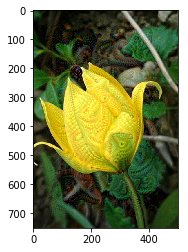

In [51]:
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img,shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shunk_original_img = resize_img(shrunk_original_img,shape)
    same_size_original =  resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shunk_original_img

    img += lost_detail
    shrunk_original_img  = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale' + str(shape) + '.png')

save_img(img, fname=drive_root_dir + 'final_dream.png')

from PIL import Image
from matplotlib import pylab as plt
result = np.array(Image.open(drive_root_dir + 'final_dream.png'))
plt.imshow(result)